In [53]:
import pandas as pd
from isbtchot.model import btc_hist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from sklearn.linear_model import LinearRegression

In [54]:
df = btc_hist()[["Close"]].rename({"Close":"price"}, axis=1)
YEARS_PREDICTION = 20

# Adjust for genesis block
GENESIS_DELTA = (df.index[0] - pd.Timestamp(year=2009, month=1, day=3)).days
df["days"] = np.arange(len(df)) + GENESIS_DELTA



In [55]:
# Applying log transformation
X_log = np.log(df['days'].values.reshape(-1, 1))
y_log = np.log(df['price'].values)

# Fit the linear regression model on the log-transformed data
power_law_model = LinearRegression().fit(X_log, y_log)

# The coefficient 'b' is the slope of the line in the log-log space
b = power_law_model.coef_[0]
# The coefficient 'a' is obtained by taking the exponential of the intercept in the log-log space
a = np.exp(power_law_model.intercept_)

# Print the model
a, b

(2.7462000964541518e-17, 5.706276312521767)

In [56]:
periods = 365 * YEARS_PREDICTION
df = pd.concat([df, pd.DataFrame(
    {
        "days": np.arange(periods) + df.days[-1],
    },
    index=pd.date_range(df.index[-1], periods=periods, freq="D")
)])

In [57]:
# Using the power law model to predict prices across the original range of days
df['power_law'] = a * (df['days'] ** b)
df['power_law_bottom'] = df['power_law'] * 0.45
df['power_law_top'] = df['power_law'] * 3

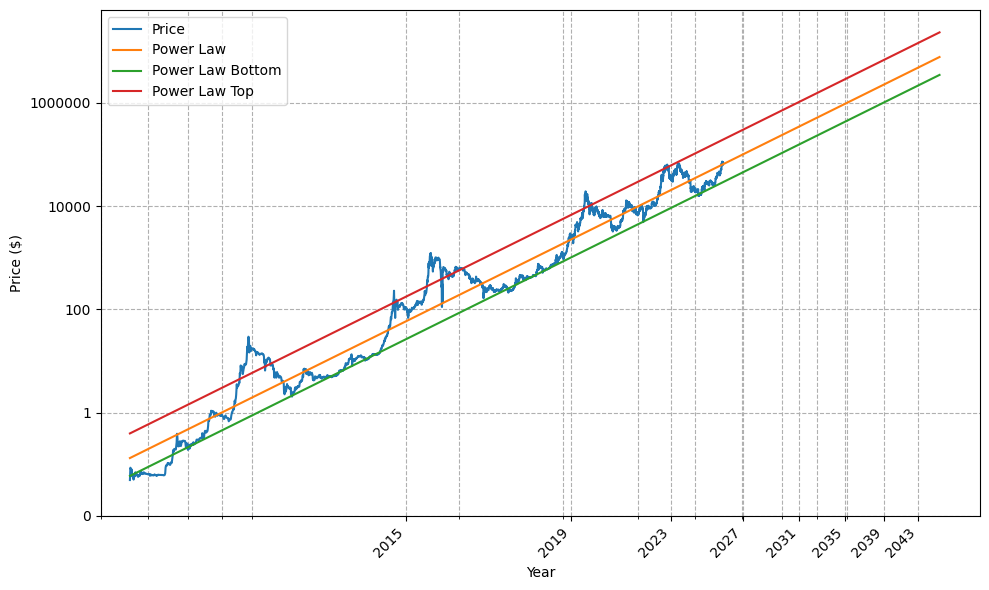

In [58]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot both 'price' and 'power_law' on a log-log scale
plt.plot(df['days'], df['price'], label='Price')
plt.plot(df['days'], df['power_law'], label='Power Law')
plt.plot(df['days'], df['power_law_bottom'], label='Power Law Bottom')
plt.plot(df['days'], df['power_law_top'], label='Power Law Top')

# Setting log scale for both x and y axis
plt.xscale('log')
plt.yscale('log')

# Find the date range
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4YS')

# Calculate the number of days since the start for each year start
xticks_yearly = [(date - df.index.min()).days for date in date_range]

# Generate yearly labels from the date_range
xticklabels_yearly = [date.strftime('%Y') for date in date_range]

# Setting ticks on the x-axis to correspond to the start of each year
plt.xticks(ticks=xticks_yearly, labels=xticklabels_yearly, rotation=45, ha='right')

# Setting the axis labels
plt.xlabel('Year')
plt.ylabel('Price ($)')

# Set the formatter for the y-axis to plain (no scientific notation)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Adding legend and grid
plt.legend()
plt.grid(True, which="both", ls="--")

# Adding limits
plt.xlim(left=500)
plt.ylim(bottom=0.01)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

In [59]:
df.dropna().tail(1)

,price,days,power_law,power_law_bottom,power_law_top
2024-04-06,68104.76,5572,65238.899839,29357.504928,195716.699517


In [63]:
df.loc[pd.Timestamp(year=2025, month=1, day=25)]


price                         NaN
days                  5866.000000
power_law            87484.921162
power_law_bottom     39368.214523
power_law_top       262454.763485
Name: 2025-01-25 00:00:00, dtype: float64